In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image

In [2]:
# Using pretrained models from library to perform image style transfer on a target image
vgg = models.vgg19(pretrained=True).features

In [3]:
for param in vgg.parameters(): # Only using parameters from the pretrained model
    param.requires_grad_(False) # Set gradiennas false to prevent weights being affected by back propagation

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [6]:
def load_image(img_path, max_size=400, shape=None): # max_size - control img size
    image = Image.open(img_path).convert('RGB')
    
    if (max(image.size) > max_size):
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),
                             (0.5, 0.5, 0.5))
    ])
    
    image = in_transform(image).unsqueeze(0)
    
    return image

In [45]:
content = load_image('Images\Lena_KC.jpg').to(device)
style = load_image('Images\StarryNight.jpg', shape=content.shape[-2:]).to(device)

In [46]:
# Convert img to tensor
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() # convert data into numpy array
    image = image.squeeze() # show compatibility
    image = image.transpose(1, 2, 0)
#    print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

(-0.5, 532.5, 399.5, -0.5)

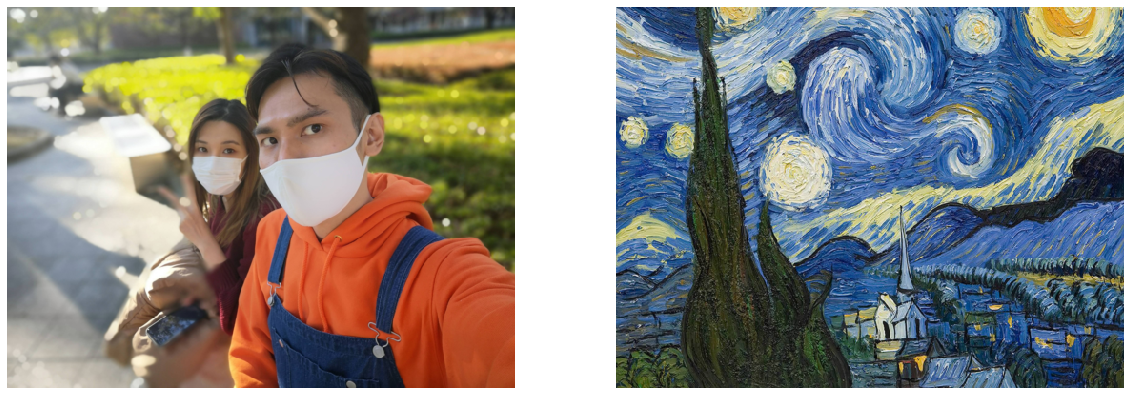

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')

In [48]:
def get_features(image, model):
    layers = {'0': 'conv1_1',
              '5': 'conv2_1',
              '10':'conv3_1',
              '19': 'conv4_1',
              '21': 'conv4_2', # content extraction
              '28': 'conv5_1'}

    features = {}
    
    for name, layer in model._modules.items():
        image = layer(image)
        
        if name in layers:
            features[layers[name]] = image
            
    return features        

In [49]:
# Extract features from content and style image, transfer to final target image
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [50]:
# Continue 11/6/2020
def gram_matrix(tensor):
    _, d, h, w = tensor.size() # breadth (not used), depth, height, width
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t()) # gram = multiply of tensor and tensor transpose
    return gram

In [51]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [52]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1 # alpha
style_weight = 1e6 # beta

In [53]:
target = content.clone().requires_grad_(True).to(device)

In [54]:
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 2100

height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))

capture_frame = steps/300
counter = 0

Total loss:  7576724.5
Iteration:  300


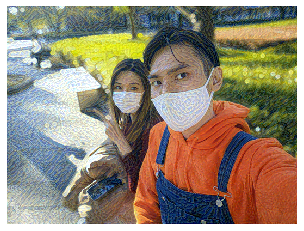

Total loss:  3156096.0
Iteration:  600


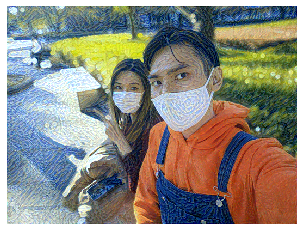

Total loss:  1427264.75
Iteration:  900


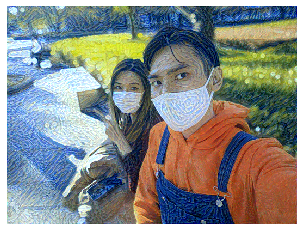

Total loss:  792620.8125
Iteration:  1200


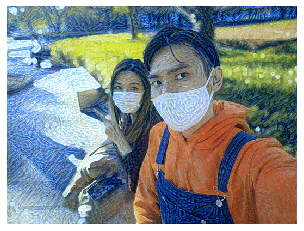

Total loss:  526932.25
Iteration:  1500


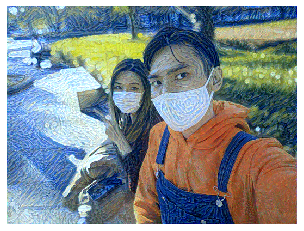

Total loss:  382089.6875
Iteration:  1800


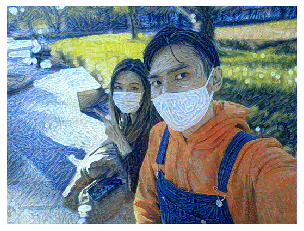

In [ ]:
for ii in range (1, steps+1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    style_loss = 0
    
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = torch.mean((target_gram - style_gram)**2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)
    
    total_loss = (content_loss*content_weight) + (style_loss * style_weight)
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        print('Iteration: ', ii)
        plt.imshow(im_convert(target))
        plt.axis('off')
        plt.show()
    
    if ii % capture_frame == 0:
        image_array[counter] = im_convert(target)
        counter = counter + 1

(-0.5, 532.5, 399.5, -0.5)

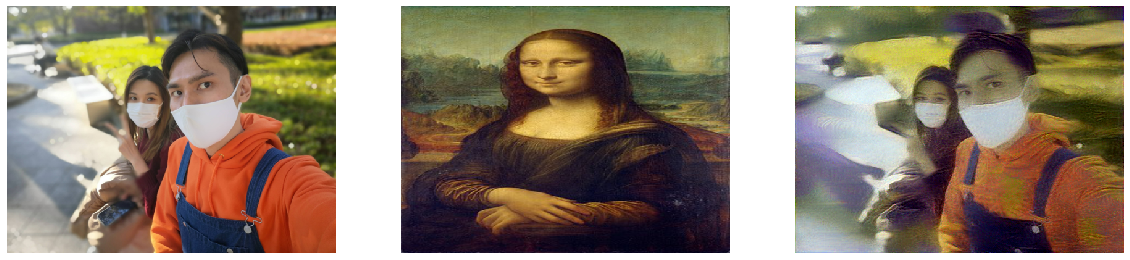

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

In [42]:
import cv2

frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('output_2.mp4', cv2.VideoWriter_fourcc(*'XVID'),30, (frame_width, frame_height))

for i in range(0, 300):
    img = image_array[i]
    img = img * 255
    img = np.array(img, dtype=np.uint8) # convert to np array
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vid.write(img)
    
vid.release()

In [43]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [44]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 186F-50FD

 Directory of C:\Users\user\Documents\Projects\PythonTutorial\Pytorch Tutorial

11/06/2020  06:08 PM    <DIR>          .
11/06/2020  06:08 PM    <DIR>          ..
11/05/2020  04:35 PM    <DIR>          .ipynb_checkpoints
10/17/2020  09:37 PM    <DIR>          ants_and_bees
10/15/2020  01:17 PM    <DIR>          data
11/06/2020  05:57 PM    <DIR>          Images
11/05/2020  04:32 PM         1,704,104 Images.zip
11/06/2020  05:56 PM         3,506,265 Images+2.zip
11/06/2020  06:08 PM         1,009,694 output.mp4
10/11/2020  01:15 PM            23,279 Python Crash Course - Numpy.ipynb
10/15/2020  03:10 PM           451,738 Pytorch CNN - Training with CIFAR10 dataset.ipynb
10/15/2020  02:28 PM           122,144 Pytorch Convolutional Neural Networks.ipynb
10/11/2020  01:15 PM           123,301 Pytorch image recognition with MNIST datasets.ipynb
11/06/2020  06:08 PM         2,975,273 Pytorch Image Style Transfer.ipynb
10/31